In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import theano
theano.config.openmp = True

%matplotlib inline
%env OMP_NUM_THREADS=12

Using Theano backend.


env: OMP_NUM_THREADS=12


In [2]:

def create_dataset_lags(dataset, signal, nblags=1):
    df = dataset.copy();
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        df[name] = dataset[signal].shift(i+1);
    return df

In [3]:
def load_dataset(source , signal):
    dataframe = pandas.read_csv('../data/ozone-la.csv', usecols=[1], engine='python')
    return dataframe;

def get_lag_names(signal, nblags):
    names = [];
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        names.append(name);
    return names;

def cut_dataset(dataframe , signal, lags):
    train_size = int(dataframe.shape[0] * 0.67)
    lagged_df = create_dataset_lags(dataframe, signal, lags)
    (train_df, test_df) = (lagged_df[0:train_size] , lagged_df[train_size:])
    return (train_df , test_df)

In [4]:
# create and fit the LSTM network

def train_model(train_df , signal, lags, epochs):
    model = Sequential()
    model.add(LSTM(4, input_dim=lags))
    
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='adam')
    
    lag_names = get_lag_names(signal , lags);
    trainX = train_df[lag_names][lags:].values
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainY = train_df[signal][lags:].values

    lHistory = model.fit(trainX, trainY, nb_epoch=epochs, batch_size=1, validation_split=0.1, verbose=0)
    print(lHistory.__dict__)
    return model;

def plot_model(model):
    from IPython.display import SVG
    from keras.utils.visualize_util import model_to_dot

    SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

    

In [5]:
# make predictions

def compute_L2_MAPE(signal , estimator):
    lMean = numpy.mean( (signal - estimator)**2 );
    lMAPE = numpy.mean( numpy.abs((signal - estimator) / signal ));
    lL2 = numpy.sqrt(lMean);
    return (lL2 , lMAPE);


def predict_signal(model, signal, nblags, train_df, test_df, idataframe):
    lag_names = get_lag_names(signal , nblags);
    trainX = train_df[lag_names].values
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainPredict = model.predict(trainX)
    testX = test_df[lag_names].values
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict = model.predict(testX)
    
    # calculate root mean squared error
    lTrainL2 = compute_L2_MAPE(train_df[signal][nblags:].values, trainPredict[nblags:])
    lTestL2 = compute_L2_MAPE(test_df[signal].values, testPredict)
    print('TRAIN_TEST_RMSE_MAPE', lTrainL2 , lTestL2)

    out_df = pandas.DataFrame()
    out_df = idataframe.copy();
    out_N = out_df.shape[0]
    out_df['Time'] = range(out_N)
    # out_df['scaled_output'] = 0;
    lSeries = pandas.Series();
    lSeries[:] = numpy.nan
    lSeries1 = pandas.Series(trainPredict.ravel());
    lSeries2 = pandas.Series(testPredict.ravel());
    # print(out_N , lSeries.shape[0], lSeries1.shape[0], lSeries2.shape[0])
    lSeries = lSeries.append(lSeries1);
    lSeries = lSeries.append(lSeries2);
    out_df['output'] = lSeries.values;
    out_df['output'] = out_df['output'];
    return out_df;



In [6]:

def full_test(nblags , epochs):
    lSignal = 'Ozone';
    ozone_df = load_dataset('../data/ozone-la.csv' , lSignal);
    (train_df, test_df) = cut_dataset(ozone_df, lSignal , nblags);
    model = train_model(train_df, lSignal , nblags, epochs);
    plot_model(model);
    out_df = predict_signal(model, lSignal, nblags, train_df, test_df, ozone_df);
    lNewName = lSignal + "_" + str(nblags) +  "_" + str(epochs) 
    out_df[lNewName] = out_df[lSignal]
    out_df.plot('Time' , [lNewName,  'output'] , figsize=(22,12));

    
    

{'params': {'nb_epoch': 320, 'verbose': 0, 'batch_size': 1, 'nb_sample': 116, 'do_validation': True, 'metrics': ['loss', 'val_loss']}, 'model': <keras.models.Sequential object at 0x7f192f0d4ba8>, 'history': {'loss': [79.777997164890678, 50.267920485858262, 43.569415565194753, 39.853183674401251, 37.376322163590068, 36.067599037084086, 35.114978472734322, 34.098724085709144, 32.950406707823277, 31.936014450829603, 30.875225497795075, 29.904761059530848, 29.242378291128009, 28.316052262574949, 27.676386955997039, 26.963881811705129, 26.457180339457661, 25.875934572826171, 25.346462956790266, 25.100291044547639, 24.454675560881352, 24.30565508384386, 23.772083038110928, 23.440862524612196, 23.137628805341905, 22.661919093337552, 22.505658412801807, 22.482707495833264, 22.235497241325934, 22.295615890159688, 21.765079245485108, 21.681460611522198, 21.725685021502834, 21.584133164122186, 21.371572134823634, 21.397440794726897, 21.370277308955274, 21.258729883822902, 21.123729500999868, 20.9

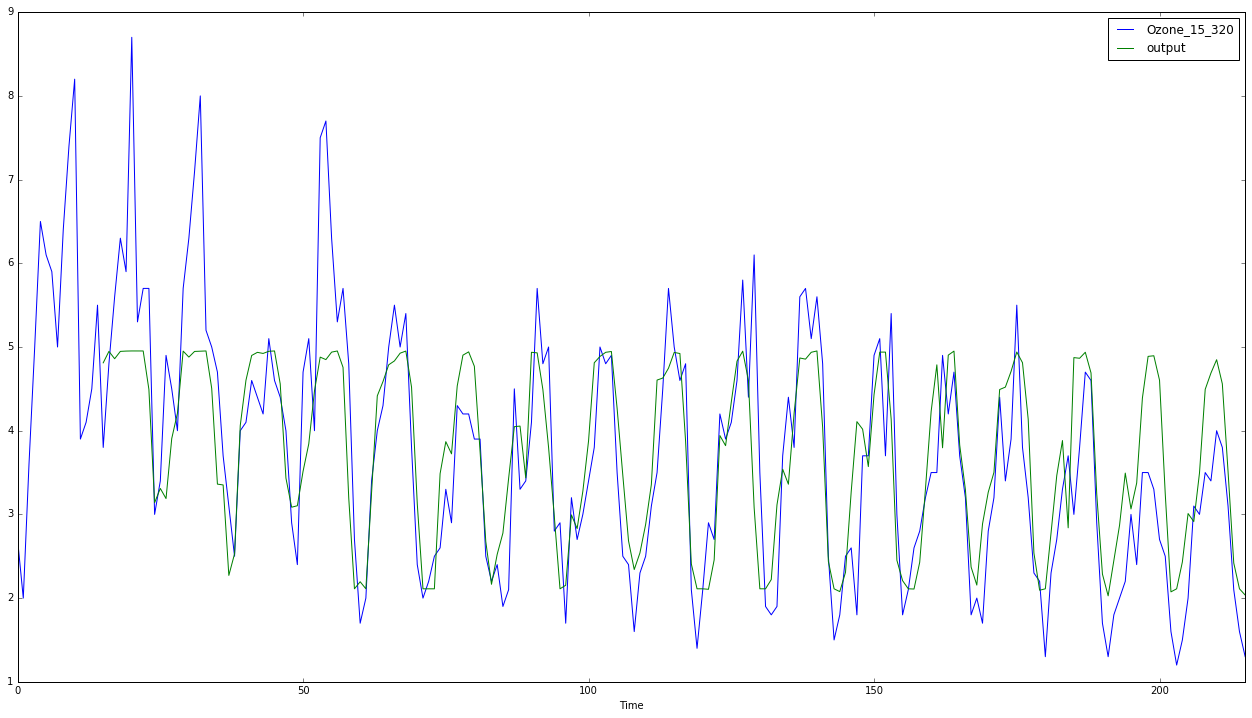

In [7]:
full_test(15, 320)

{'params': {'nb_epoch': 10, 'verbose': 0, 'batch_size': 1, 'nb_sample': 122, 'do_validation': True, 'metrics': ['loss', 'val_loss']}, 'model': <keras.models.Sequential object at 0x7f18b1251d68>, 'history': {'loss': [114.89937410198274, 99.351943031686247, 77.773136576668165, 71.858540581875161, 65.812570165415281, 54.710014050124123, 46.857090211305461, 42.083280874813191, 38.994529226764307, 37.213757470005845], 'val_loss': [114.35175105503627, 77.257588795253213, 69.574787412370952, 62.65250301361084, 52.420671292713713, 42.368659002440317, 41.300891126905171, 41.121896437236238, 40.994067498615813, 41.534202507563997]}, 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
TRAIN_TEST_RMSE_MAPE (2.1466460937491072, 0.37122781098860319) (1.128126862040113, 0.32552527258334568)
{'params': {'nb_epoch': 10, 'verbose': 0, 'batch_size': 1, 'nb_sample': 100, 'do_validation': True, 'metrics': ['loss', 'val_loss']}, 'model': <keras.models.Sequential object at 0x7f18b3bdc240>, 'history': {'loss': [92.49061

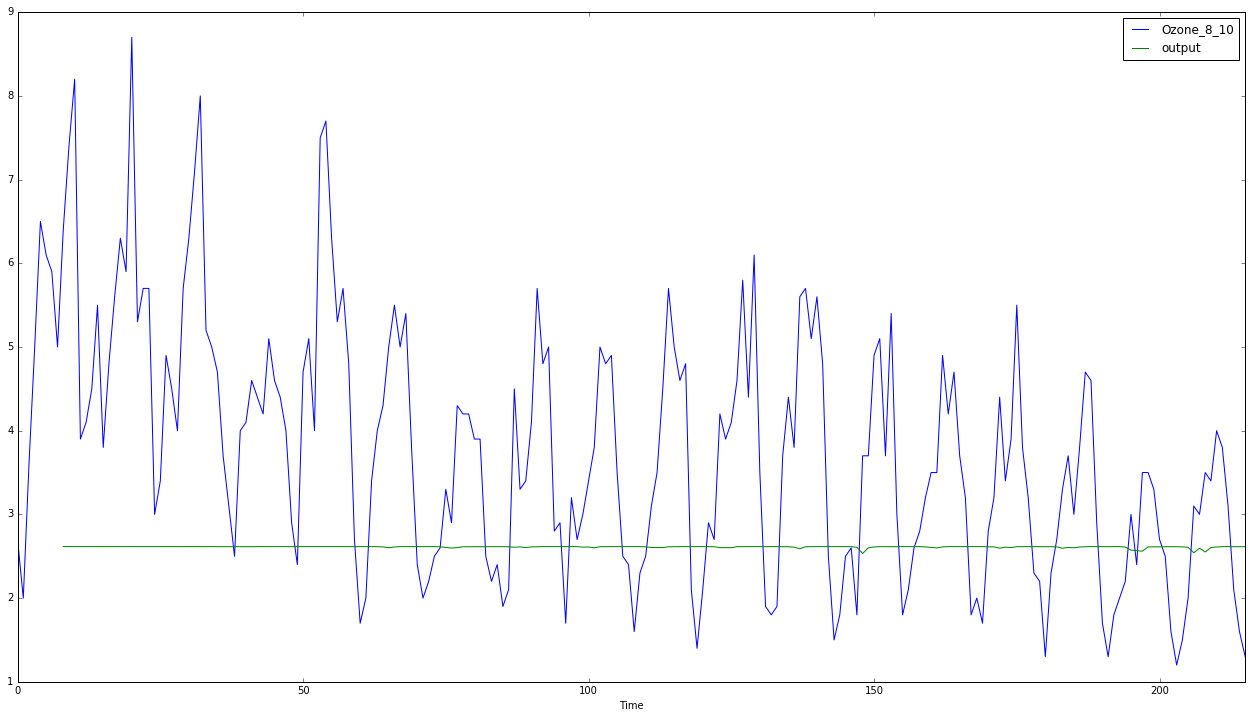

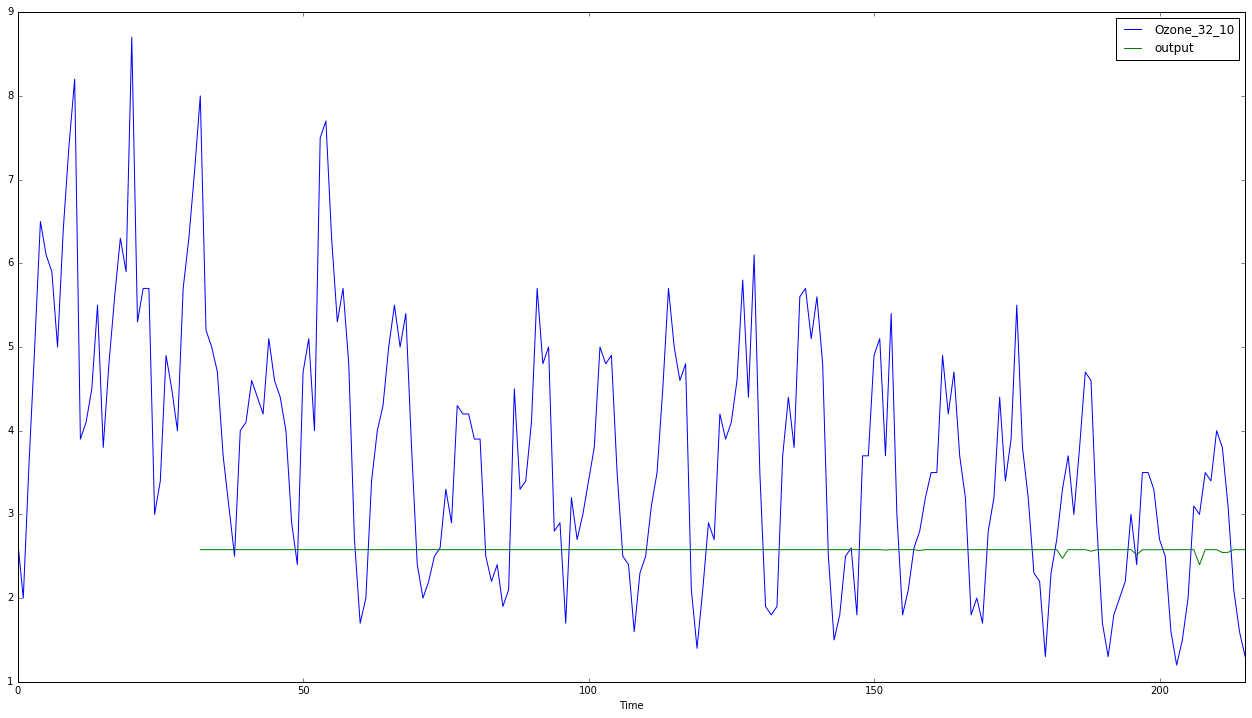

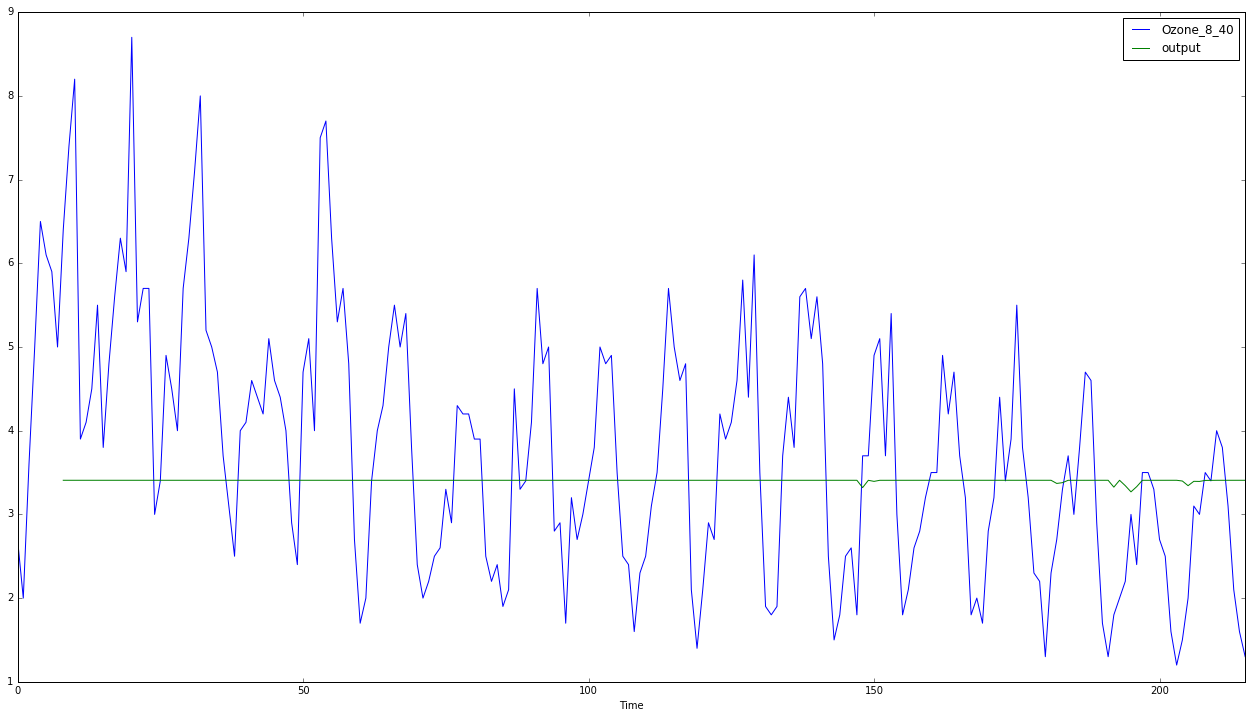

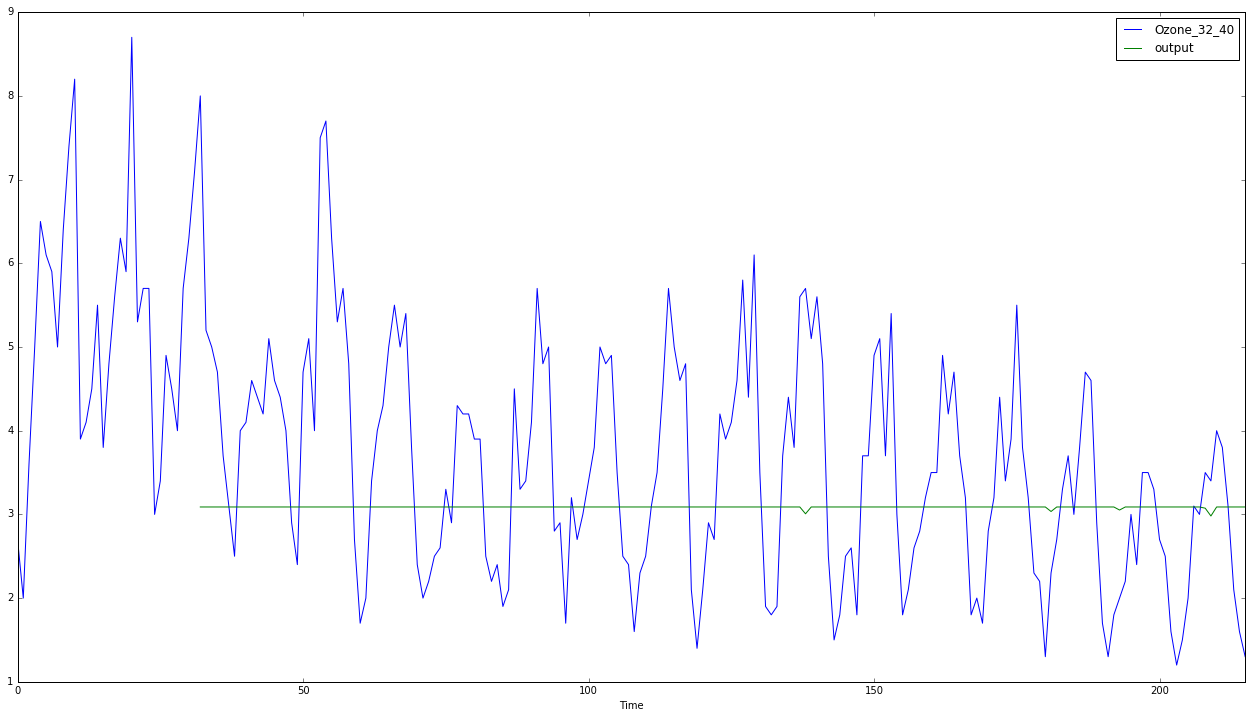

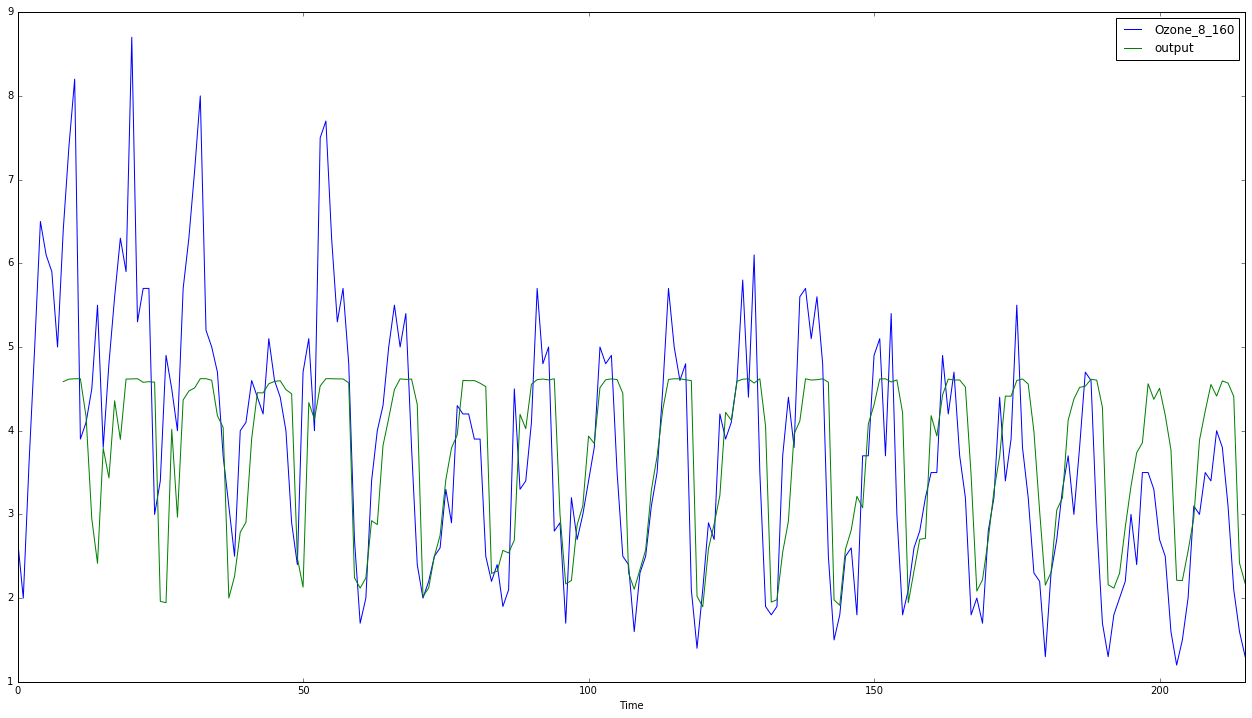

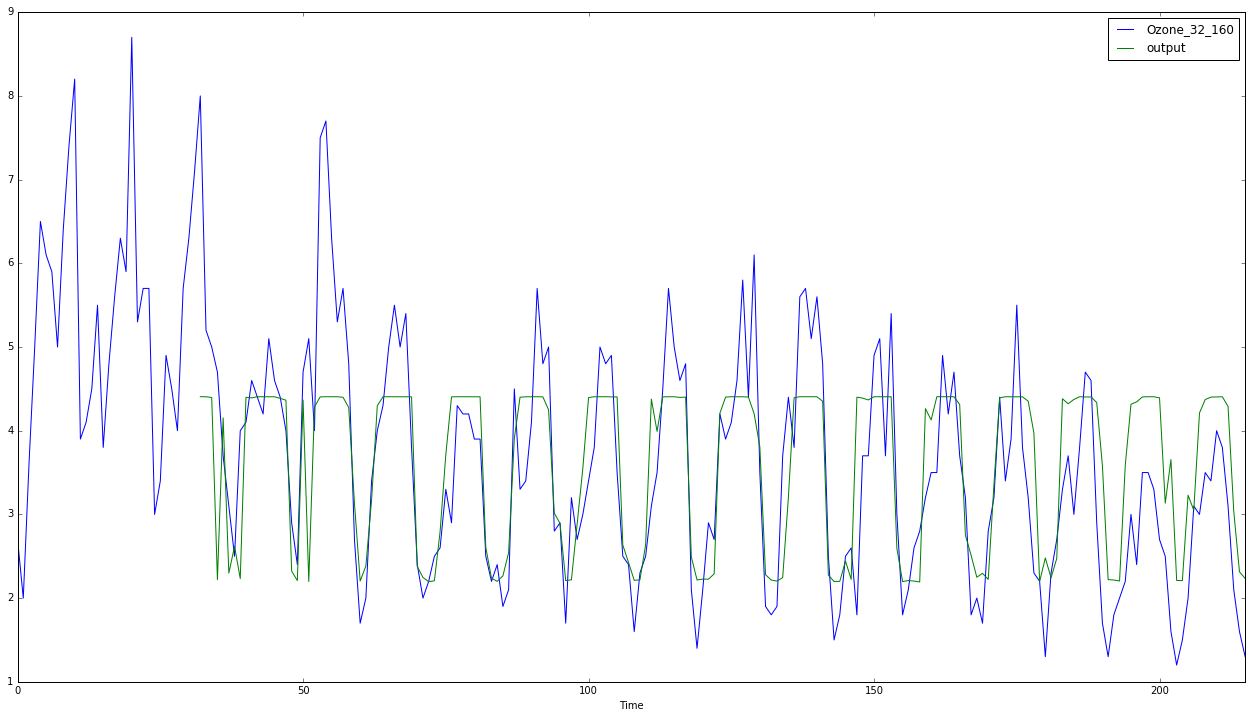

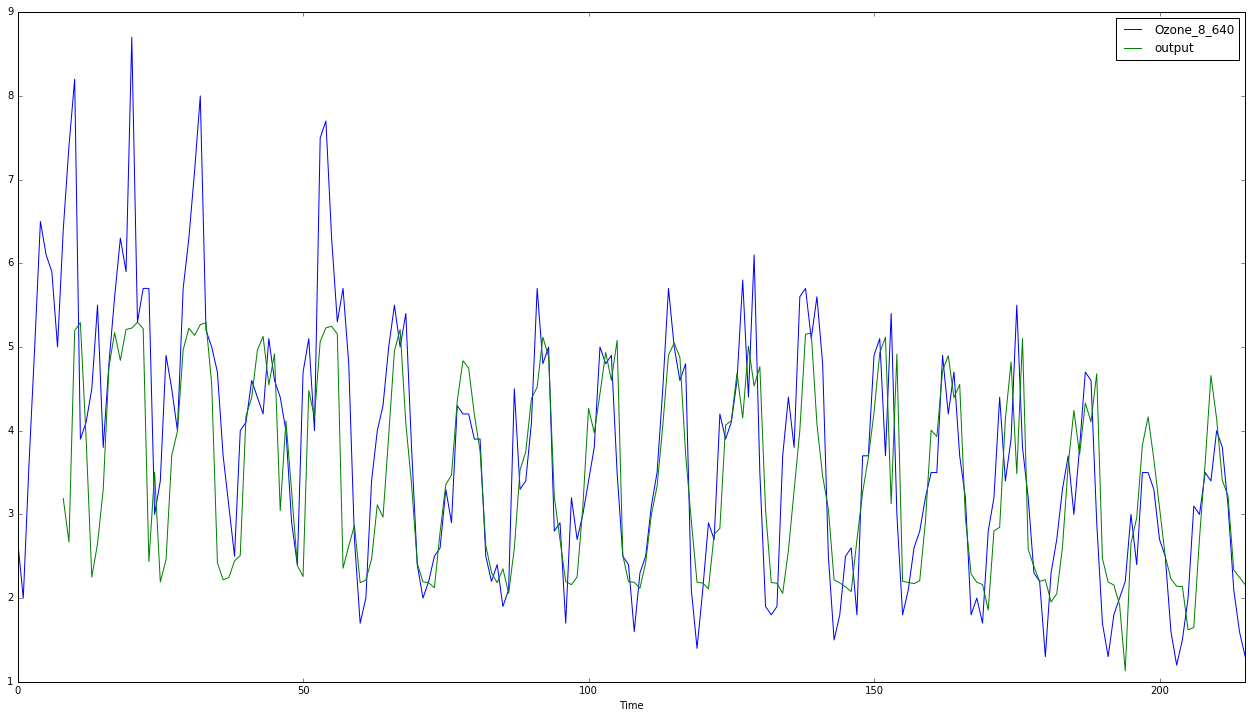

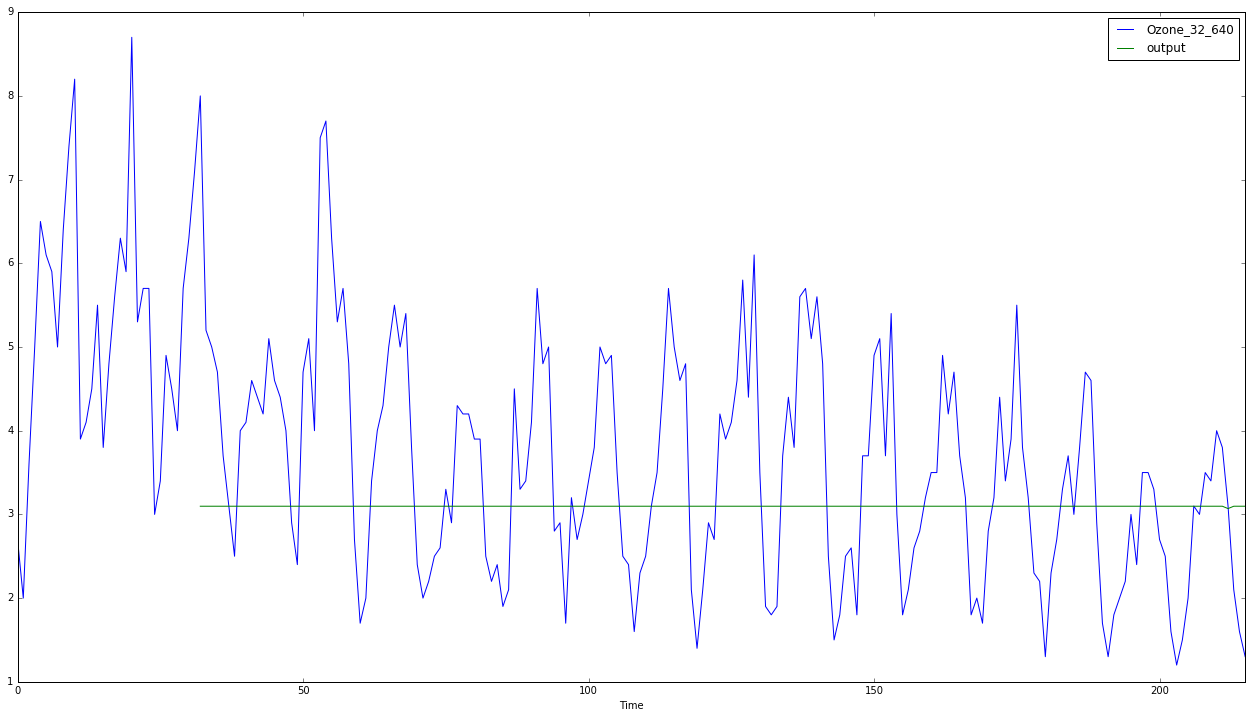

In [8]:
for ep in [10 , 40, 160, 640]:
    for lags in [8 ,32]:
        full_test(lags, ep)


In [9]:
s=pandas.Series();

In [10]:
s.name

In [11]:
mod0 = Sequential();

In [12]:
mod0.ge

AttributeError: 'Sequential' object has no attribute 'ge'